# Analysis of network model results

In [1]:
%load_ext autoreload
%autoreload 2

from keras.models import load_model
from src.models.data import *
from src.models.model import *
from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc
#import rasterio.plot as rioplot
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib.image as mpimg

import skimage.io as io
from sklearn.metrics import roc_auc_score, roc_curve

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

Using TensorFlow backend.


## User settings

In [2]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# base directory with data (image tiles) to be analyzed
eval_dir = "../../data/validate"
# subdirs
dir_x = 'sat'
dir_y = 'map'

# max. number of samples (files) to analyze (predicition can be slow)
max_num_x = 5

# size of images
target_size = (512,512)

# path to & filename of model to analyze
trained_model_fn = '../../models/unet_membrane_analytic_27_08_14_55.hdf5'
# list any custom loss or metric functions of the model here
custom_objects = {'auc_roc': auc_roc}

# individual samples to be shown: either None, a list of indexes, or any of 'random', 'head_tail'
# in the latter two cases, up to ten images will be picked; head_tail = the five best and the five worst-predicted
show_samples = "random"
show_samples = "head_tail"

# colormap to be used for road label tile 
cmap_yscore = 'gray'

# input arguments to Keras' ImageDataGenerator - be sure not to include any image augmentation here!
data_gen_args = dict(data_format="channels_last")

# batch size for summary stats without visualization (the more, the more efficient, but limited by memory)
batch_size = 3

### Some preparatory computations

In [3]:
# list of satellite image files & their number
_, _, file_list_x = next(os.walk(os.path.join(eval_dir, dir_x)))
num_x = len(file_list_x)

# actual number of files that will be analyzed, given files available
num_x_use = min(num_x, max_num_x)

# default number of samples to plot in detail
NUM_X_SHOW = 2

# actual number of samples that can be shown, given number of samples to be analyzed
num_x_show = np.min([NUM_X_SHOW, num_x_use])

# 'steps' input par into evaluate_generator
steps =  num_x_use // batch_size

### Load complete model
The additional input arg "custom_objects" is needed if custom loss or metrics were used in the model

In [4]:
model = load_model(trained_model_fn, custom_objects=custom_objects)

### Loop over files, collecting data & predicitions (takes a long time)

In [5]:
# number of pixels per image
img_size = np.prod(target_size)
# preallocate arrays collecting the label (y) values and y scores of all samples
arr_y = np.empty(img_size * num_x_use, dtype=np.float32)
arr_yscore = np.empty(img_size * num_x_use, dtype=np.float32)
# define key metric
metric = roc_auc_score
# array collecting the key metric for each sample individually
arr_metric = np.empty(num_x_use)

for i, fn in enumerate(file_list_x[:num_x_use]):
    print("analyzing {} ...".format(fn))
    # read sat image tile
    x = io.imread(os.path.join(eval_dir, dir_x, fn)) / 255.0
    # read corresponding label tile
    y = io.imread(os.path.join(eval_dir, dir_y, fn)) // 255
    # copy flattened labels in array
    arr_y[i*img_size:(i+1)*img_size] = y.ravel()
    # predict
    yscore = model.predict(x.reshape((1,) + target_size +(4,)))
    # copy flattened prediction in array
    arr_yscore[i*img_size:(i+1)*img_size] = yscore.ravel()
    # compute and store metric
    arr_metric[i] = metric(y.ravel(), yscore.ravel())

analyzing 20180427_020503_103c_3B_0019.tif ...
analyzing 20180427_020503_103c_3B_0020.tif ...
analyzing 20180427_020503_103c_3B_0027.tif ...
analyzing 20180427_020503_103c_3B_0028.tif ...
analyzing 20180427_020503_103c_3B_0035.tif ...


In [6]:
# depending on which samples are to be shown, sort results
if show_samples == "random":
    samples_ix = np.random.choice(num_x_use, num_x_show, replace=False)
elif show_samples == "head_tail":
    # indexes to best and worst examples
    ix_sorted = np.argsort(arr_metric)
    samples_ix = np.hstack((ix_sorted[:(num_x_show//2)],ix_sorted[(-num_x_show//2):]))
elif type(show_samples) is list:
    samples_ix = np.array(show_samples, dtype=int)
    samples_ix = samples_ix[samples_ix < num_x_use]

### Compute metrics on all data

In [7]:
auc = roc_auc_score(arr_y, arr_yscore)
# ROC curve
fpr, tpr, thresholds = roc_curve(arr_y, arr_yscore, pos_label=1)

### Summary figure

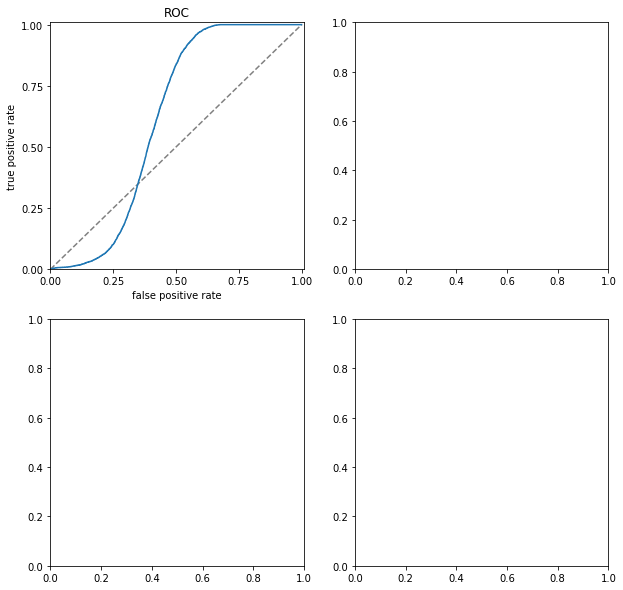

In [8]:
def plot_auc(fpr, tpr, ax):
    # plot diagonal
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), linestyle='--', color='gray')
    ax.plot(fpr, tpr)
    ax.set_yticks(np.arange(0, 1.25, 0.25))
    ax.set_xticks(np.arange(0, 1.25, 0.25))
    ax.set_ylim(0, 1.01)
    ax.set_xlim(0, 1.01)
    ax.set(title='ROC', xlabel='false positive rate', ylabel='true positive rate')

# set up summary figure
fig_sum, axs = plt.subplots(2, 2, figsize=(10, 10))


plot_auc(fpr, tpr, axs[0, 0])
plt.show()

### Show individual samples

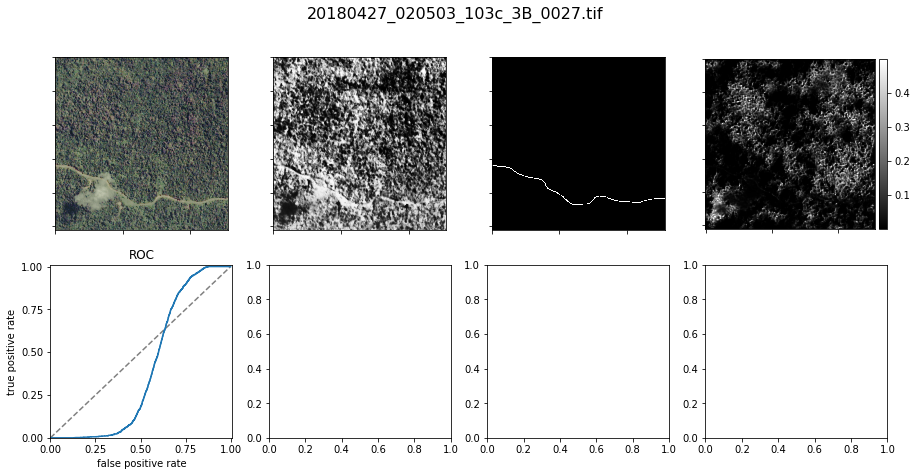

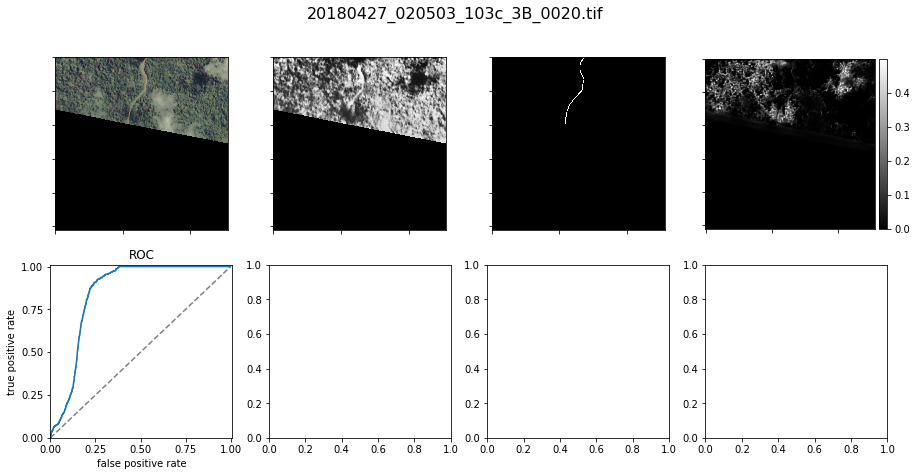

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_tile(tile, ax, cmap=None, show_colorbar=False):
    im_h = ax.imshow(tile, cmap=cmap);
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if show_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im_h, cax=cax)
    return im_h

for ix in samples_ix:
    fn = file_list_x[ix]
    # read sat image tile
    x = io.imread(os.path.join(eval_dir, dir_x, fn))
    # read corresponding label tile
    y = io.imread(os.path.join(eval_dir, dir_y, fn))
    # generate a binary unraveled version (for now)
    y_binary = y.ravel()
    y_binary[y_binary>0] = 1
    # retrieve y score (prediction)
    yscore = arr_yscore[ix*img_size:(ix+1)*img_size]
    # ----------------set up figure ---------------
    fig_sample, axs = plt.subplots(2, 4, figsize=(15, 7))
    fig_sample.suptitle(fn, fontsize=16)
    # plot rgb part of image
    show_tile(x[:,:,[2, 1, 0]], axs[0,0]);
    # nir
    show_tile(x[:,:,3], axs[0,1], cmap="gray");
    # labels § to be replaced by Lisa's code
    show_tile(y, axs[0,2], cmap="gray");
    # y score (prediction)
    show_tile(yscore.reshape(target_size), axs[0,3], cmap=cmap_yscore, show_colorbar=True);
    # auc
    fpr_sample, tpr_sample, _ = roc_curve(y_binary, yscore, pos_label=1)
    plot_auc(fpr_sample, tpr_sample, axs[1,0])


In [10]:
# don't run stuff below (which is not used currently but may come in handy later)
sys.exit()

SystemExit: 

/home/hh/anaconda3/envs/geo/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Run evaluation: only numeric values

In [ ]:
# set up test gen with a batch size as large as possible for efficiency reasons
test_gen = trainGenerator(batch_size, eval_dir, img_dir, label_dir,
                        data_gen_args, save_to_dir = None, image_color_mode="rgba", target_size=target_size)
res = model.evaluate_generator(test_gen, steps=steps, workers=1, use_multiprocessing=True, verbose=1)

In [ ]:
model.metrics_names
res

### Run prediction for display of images and more sophisticated evaluation

In [ ]:
pred = model.predict_generator(test_gen, steps=steps, workers=1, use_multiprocessing=True, verbose=1)

In [ ]:
plt.imshow(pred[5].reshape(target_size), cmap='gray');
plt.colorbar()

### Set up ImageDataGenerator

In [ ]:
# this generator is supposed to yield single images and matching labels, hence batch size = 1
#batch1_test_gen = trainGenerator(1, eval_dir, img_dir, label_dir,
#                        data_gen_args, save_to_dir = None, image_color_mode="rgba", target_size=target_size)
# preallocate linear arrays for collecting flattened predicition and label data